# PINN求解Burgers方程

Burgers equation ($x\in [-1,1],t\in[0,1]$):
$$
\begin{aligned}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}\\
u(x,0) = -\sin(\pi x)\\
u(-1,t) = u(1,t) = 0
\end{aligned}
$$

首先用DEVITO求得解作为ground truth

In [31]:
import math
import numpy as np

nx = 201
dx = 0.01
dt = 0.002
nu = 0.01
nt = int(1/dt)+1
U = np.zeros([nt, nx], dtype=np.float32)
U[0] = [-math.sin(math.pi * (i / 100 - 1)) for i in range(201)]
U[:, 0] = U[:, -1] = 0.

$$
u_k^{t+1} = u_k^t +dt(-u_k^t\cdot\frac{u_{k+1}^{t}- u_k^t}{d x}+\nu\cdot \frac{u_{k+1}^t - 2 u_{k}^t+u_{k-1}^t}{d x^2})
$$

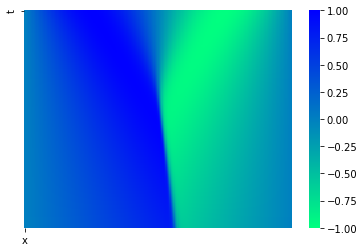

In [32]:
for i in range(nt - 1):
    U[i + 1,
      1:(-1)] = U[i, 1:(-1)] + (dt/dx) * (U[i, 2:] - 2 * U[i, 1:(-1)] + U[i, 0:(
          -2)]) - (dt/dx)*(nu/dx) * U[i, 1:(-1)] * (U[i, 2:] - U[i, 1:(-1)])

import seaborn as sns

h0 = sns.heatmap(U,
                 xticklabels='x',
                 yticklabels='t',
                 cmap='winter_r',
                 center=0)

## 采样

In [3]:
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [4]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, Sequential
from torch.utils.tensorboard import SummaryWriter
import torch.functional as F

In [33]:
def int0(n=1000):
    x = torch.rand(n, 1)
    x1 = 2 *x  - 1
    t = torch.rand(n, 1)
    cond = torch.zeros_like(t)
    return x.requires_grad_(True), t.requires_grad_(True), cond


def cond1(n=100):
    x = torch.rand(n, 1)
    x1 = 2 * x - 1
    t = torch.zeros_like(x)
    cond = -torch.sin(torch.pi * x1)
    return x.requires_grad_(True), t.requires_grad_(True), cond


def cond2(n=100):
    t = torch.rand(n, 1)
    x = torch.ones_like(t)
    cond = torch.zeros_like(t)
    return x.requires_grad_(True), t.requires_grad_(True), cond


def cond3(n=100):
    t = torch.rand(n, 1)
    x = torch.zeros_like(t)
    cond = torch.zeros_like(t)
    return x.requires_grad_(True), t.requires_grad_(True), cond

## 定义网络

In [13]:
class MLP(torch.nn.Module):
    # (2,32,32,32,32,1) with tanh()
    def __init__(self):
        super(MLP, self).__init__()
        self.net = torch.nn.Sequential(torch.nn.Linear(2, 32), torch.nn.Tanh(),
                                       torch.nn.Linear(32,
                                                       32), torch.nn.Tanh(),
                                       torch.nn.Linear(32,
                                                       32), torch.nn.Tanh(),
                                       torch.nn.Linear(32, 32),
                                       torch.nn.Tanh(), torch.nn.Linear(32, 1))

    def forward(self, x):
        return self.net(x)

## 损失函数

In [34]:
loss = torch.nn.MSELoss()


def gradients(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(
            u,
            x,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            only_inputs=True,
        )[0]
    else:
        return gradients(gradients(u, x), x, order=order - 1)


def l0(u):
    x, y, cond = int0()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(
        gradients(uxy, y, 1) + 2*uxy * gradients(uxy, x, 1) -4*
        nu * gradients(uxy, x, 2), cond)


def l1(u):
    x, y, cond = cond1()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


def l2(u):
    x, y, cond = cond2()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


def l3(u):
    x, y, cond = cond3()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)

## 训练

In [46]:
u = MLP()
opt = torch.optim.Adam(params=u.parameters())

for i in range(5000):
    opt.zero_grad()
    l = l0(u) + l1(u) + l2(u) + l3(u)
    l.backward()
    opt.step()

KeyboardInterrupt: 

## 测试

### 测试格点定义

In [79]:
xc = torch.linspace(0, 1, 101)
xc1 = torch.linspace(0, 1, 501)
xx, yy = torch.meshgrid(xc, xc1)
xx = xx.reshape(-1, 1)
yy = yy.reshape(-1, 1)
xy = torch.cat([xx, yy], dim=1)

In [80]:
u_tmp = u(xy).reshape([501, 101])

<AxesSubplot:>

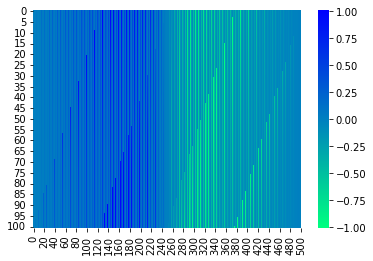

In [81]:
sns.heatmap(u_tmp.detach().numpy().T,cmap='winter_r',
                 center=0)

In [74]:
class MLP1(torch.nn.Module):
    # (2,32,32,32,32,1) with tanh()
    def __init__(self):
        super(MLP1, self).__init__()
        self.net = torch.nn.Sequential(torch.nn.Linear(2, 32), torch.nn.Tanh(),
                                       torch.nn.Linear(32,
                                                       32), torch.nn.Tanh(),
                                       torch.nn.Linear(32,
                                                       32), torch.nn.Tanh(),
                                       torch.nn.Linear(32, 32),
                                       torch.nn.Tanh(), torch.nn.Linear(32, 1))

    def forward(self, x):
        return self.net(x)*x[:,0].reshape(-1,1)*(1-x[:,0].reshape(-1,1))


In [84]:
u1 = MLP1()
opt1 = torch.optim.Adam(params=u1.parameters())

for i in range(5000):
    opt1.zero_grad()
    l = l0(u) + l1(u)
    l.backward()
    opt1.step()

In [85]:
u_tmp1 = u1(xy).reshape([501, 101])

<AxesSubplot:>

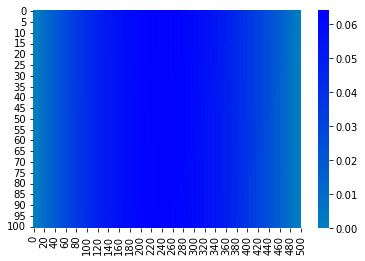

In [86]:
sns.heatmap(u_tmp1.detach().numpy().T,cmap='winter_r',
                 center=0)